# Future predictions

In this notebook we train and calibrate our best-performing model using all available data to predict whether or not a given player will play in the NBA _at any point_ during the 2024-2025 season.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from HelperFunctions import *

## Loading the full dataset

In [86]:
#load/scale data
df        = pd.read_csv("full_data.csv")
df_scaled = ImputeAndScale(df.copy())
features  = df_scaled.select_dtypes(include='number').columns.drop(['PLAYER_ID', 'SEASON_START', 'IN_LEAGUE_NEXT'])

In [87]:
#make 2023-2024 season the test set
df_train = df_scaled.loc[df_scaled.SEASON_START < 2017]
df_test  = df_scaled.loc[df_scaled.SEASON_START >= 2017]

In [88]:
#split training data into a train set and a calibration set
df_tt, df_cal = train_test_split(df_train, test_size=0.2, shuffle=True, 
                                 random_state=815, stratify=df_train.IN_LEAGUE_NEXT)

## Training the model

In [89]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

model = Pipeline([('smote', SMOTE(random_state=23)),
                  ('xgb', XGBClassifier(n_estimators=350, learning_rate=0.005, random_state=206))])

model.fit(df_tt[features], df_tt.IN_LEAGUE_NEXT)

model_cal = CalibratedClassifierCV(model, cv="prefit")
model_cal.fit(df_cal[features], df_cal.IN_LEAGUE_NEXT)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('smote',
                                                  SMOTE(random_state=23)),
                                                 ('xgb',
                                                  XGBClassifier(base_score=None,
                                                                booster=None,
                                                                callbacks=None,
                                                                colsample_bylevel=None,
                                                                colsample_bynode=None,
                                                                colsample_bytree=None,
                                                                device=None,
                                                                early_stopping_rounds=None,
                                                                enable_categorical=False,
                                                                eval_metric=None,
                                                                feature_types=None,
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.005,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=None,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=350,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=206, ...))]))

In [90]:
df_2023 = df_test.copy()


df_2023["PREDICTIONS"] = model.predict(df_test[features])
df_2023["PROB"]        = final_model_cal.predict_proba(df_test[features])[:, 1]

In [91]:
features

Index(['PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT',
       'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
       'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT',
       'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'SALARY', 'WAIVED', 'RELEASED', 'TRADED', 'WAIVED_OFF',
       'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG',
       'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST'],
      dtype='object')

## Visualize training data

Make scatterplots with a choice of predictors on the x and y axes, and color the points based on `IN_LEAGUE_NEXT`.

In [92]:
def visualize_train(x, y, year):
    sns.scatterplot(data=df.loc[df.SEASON_START==year], x=x, y=y, hue="IN_LEAGUE_NEXT", palette=["lightcoral", "black"])
    plt.show()
    return None

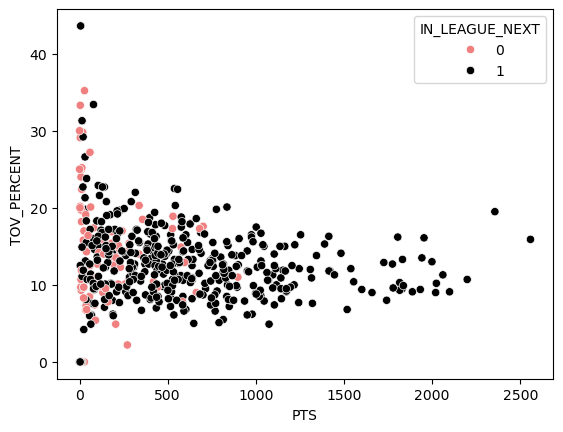

In [93]:
visualize_train("PTS", "TOV_PERCENT", 2016)

## Visualize model output

Plots arbitrary predictors on x axis vs predicted probability on y axis for unseen test data (2016-2022).

In [95]:
def visualize_test(x, y, year):
    ax = sns.scatterplot(x=df.loc[df.SEASON_START==year][x], y=df.loc[df.SEASON_START==year][y], 
                         hue=model_cal.predict_proba(df_scaled.loc[df_scaled.SEASON_START==year][features])[:, 0],
                         palette="viridis",
                         legend=False)
    # Get the colormap used by the scatterplot
    cmap = plt.colormaps.get_cmap(ax.collections[0].get_cmap().name)

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])  # Set an empty array to avoid warnings

    # Add the colorbar to the plot
    plt.colorbar(sm, ax=ax)

    plt.show()
    return None

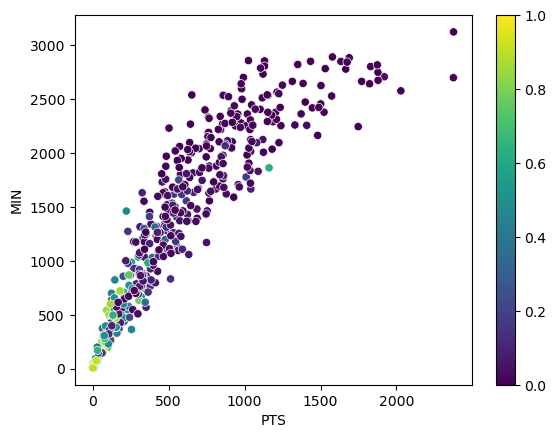

In [96]:
visualize_test("PTS", "MIN", 2015)